In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
#find the names and type of the colums 
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [12]:
# Perform a query to retrieve the data and precipitation scores
prcp_data=session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date).all()


In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_prcp = pd.DataFrame(prcp_data)
last_year_prcp.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


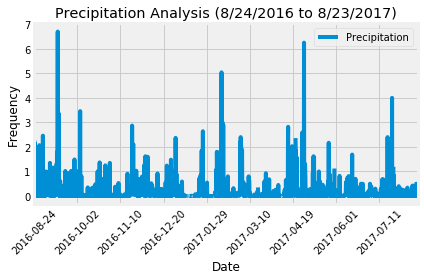

In [37]:
last_year_prcp.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title("Precipitation Analysis (8/24/2016 to 8/23/2017)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Precipitation.png")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_prcp.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
Avail_stations = session.query(Measurement).group_by(Measurement.station).count()
Avail_stations

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
Temp= session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
             filter(Station.station == active_station[0][0]).all()

Temp

[(53.0, 87.0, 73.09795396419437)]

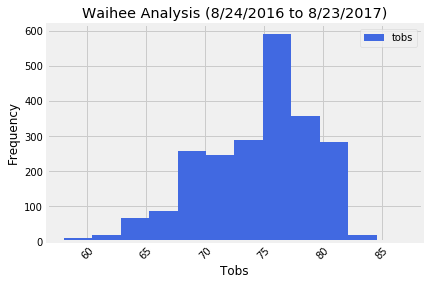

In [38]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_number= session.query(Station.name).filter(Station.station == active_station[0][0]).all() 
waihee = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date > year_ago ).\
                            filter(Station.station == active_station[0][0]).all()
waihee_df= pd.DataFrame(waihee)
plt.hist(waihee_df['tobs'],bins=12,color='royalblue')
plt.xlabel("Tobs")
plt.ylabel("Frequency")
plt.title("Waihee Analysis (8/24/2016 to 8/23/2017)")
plt.legend(["tobs"])
plt.xticks(rotation=45)
plt.tight_layout
plt.savefig("Waihee_temp(tobs).png")
plt.show()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
results = calc_temps('2016-08-01', '2016-08-12')
results

[(71.0, 78.21518987341773, 83.0)]

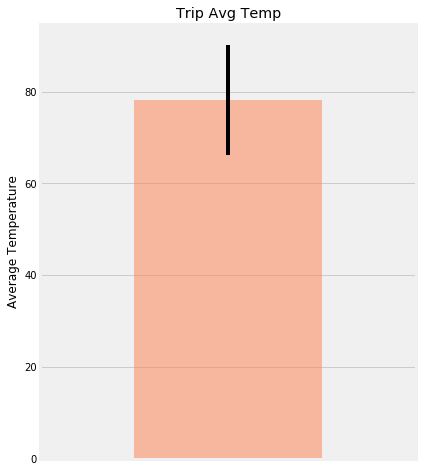

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
results_df = pd.DataFrame(results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = results_df['Avg Temp']
min_max = results_df.iloc[0]['Max Temp'] - results_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp")
plt.ylabel("Average Temperature")
plt.xticks([])
plt.savefig("Trip_avg_temp.png")
plt.show()

In [36]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_dates=dt.date(2016, 8, 12) - dt.timedelta(days=11)
trip=session.query(Measurement.station,Station.name,func.sum(Measurement.prcp),Station.latitude,Station.longitude,Station.elevation).\
filter(Measurement.date== trip_dates ).\
group_by(Measurement.station).\
order_by(func.sum(Measurement.prcp).desc()).all()

print(trip)

[('USC00519281', 'WAIKIKI 717.2, HI US', 31.770000000000003, 21.2716, -157.8168, 3.0), ('USC00513117', 'WAIKIKI 717.2, HI US', 21.150000000000002, 21.2716, -157.8168, 3.0), ('USC00516128', 'WAIKIKI 717.2, HI US', 19.890000000000004, 21.2716, -157.8168, 3.0), ('USC00519523', 'WAIKIKI 717.2, HI US', 4.86, 21.2716, -157.8168, 3.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 0.72, 21.2716, -157.8168, 3.0), ('USC00514830', 'WAIKIKI 717.2, HI US', None, 21.2716, -157.8168, 3.0)]


## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


<IPython.core.display.Javascript object>


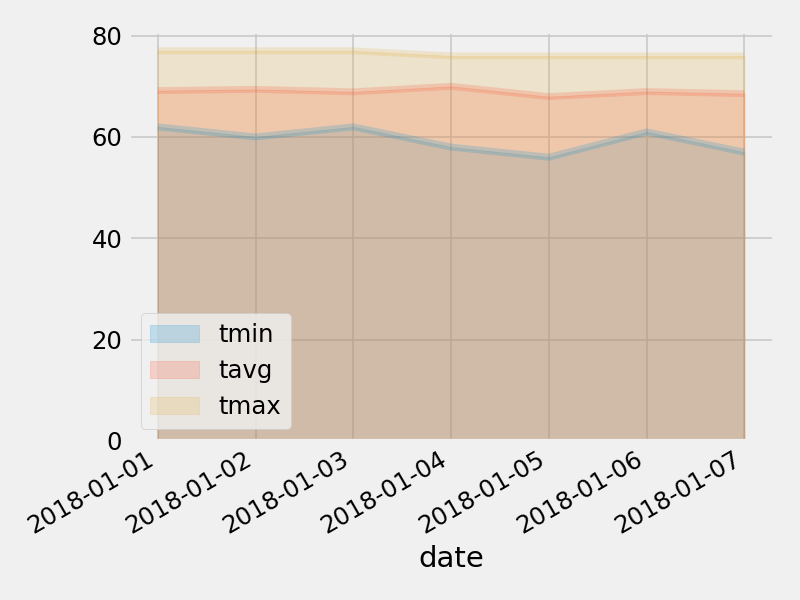

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
